In [83]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from scipy import integrate
from scipy.stats import linregress
from matplotlib import cm
from matplotlib.colors import ListedColormap
import scipy.stats as sc

In [2]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  

In [104]:
#Make some standardized coordinates

lats = np.arange(-90, 91, 1)
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g
levels_pa = np.array([100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 60000,
             70000, 85000, 92500, 100000])
levels_hPa = levels_pa / 100

confidence_level = 0.95

reanalysis_color_dict = dict(zip(['ERA5', 'MERRA', 'JRA'], ['r','k','b']))

In [6]:
amip_ds = xr.open_dataset('../amip_aht.nc')
hist_ds = xr.open_dataset('../hist_aht.nc')
reanalysis_ds = xr.open_dataset('../reanalysis_aht.nc')

amip_trends = amip_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
hist_trends = hist_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
reanalysis_trends = reanalysis_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)

In [69]:
reanalysis_std_error = xr.open_dataset('../reanalysis_ds_trend_std_error.nc')
reanalysis_Neff = xr.open_dataset('../reanalysis_ds_trend_Neff.nc')

In [88]:
def reanalysis_sig(field_vals, field_name, lat_slice):
    
    new_field_name = f"{field_name.split('_')[0]}_{field_name.split('_')[1]}"
    
    reanalysis_Neff_val = reanalysis_Neff[new_field_name].sel(latitude=lat_slice).mean('latitude')
    t_vals_reanalysis = sc.t.ppf((1 + confidence_level)/2, (reanalysis_Neff_val.values))
    t_values_reanalysis = field_vals / (40 / 1e15 * reanalysis_std_error[new_field_name].sel(latitude=lat_slice).mean('latitude'))
    sig_reanalysis = xr.where(abs(t_values_reanalysis) > t_vals_reanalysis, True, False)
    
    return sig_reanalysis

In [155]:
def violin_plot(data, ax):
    
    

    parts = ax.violinplot(data, showmedians=False, showmeans=False, showextrema=False,
                    widths=violin_width)

    for pc in parts['bodies']:
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
        pc.set_alpha(0.9)
        
    

    quartile11, median1, quartile13 = np.percentile(data[0], [25, 50, 75])
    quartile21, median2, quartile23 = np.percentile(data[1], [25, 50, 75])
    
    mean1 = np.mean(data[0])
    mean2 = np.mean(data[1])

    inds = [1, 2]
    #ax.scatter(inds, [median1, median2], marker='o', color='white', s=30, zorder=3)
    ax.scatter(inds, [mean1, mean2], marker='o', color='white', s=30, zorder=3)
    ax.vlines(1, quartile11, quartile13, color='k', linestyle='-', lw=5)
    ax.vlines(2, quartile21, quartile23, color='k', linestyle='-', lw=5)
    #ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

<ipython-input-158-46008f60c104>:49: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['A'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-158-46008f60c104>:49: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['A'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-158-46008f60c104>:80: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['B'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-158-46008f60c104>:80: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated si

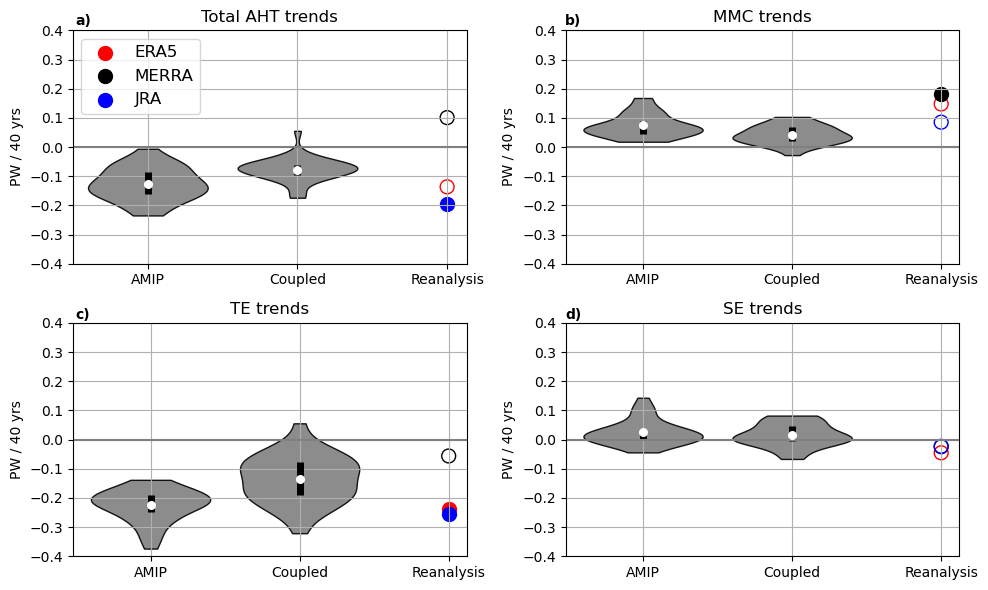

In [158]:
field1 = 'total_aht_polyfit_coefficients'
field2 = 'mmc_aht_polyfit_coefficients'
field3 = 'eddy_aht_polyfit_coefficients'
field4 = 'te_aht_polyfit_coefficients'
field5 = 'se_aht_polyfit_coefficients'
#which_lat = -60
lat_slice = slice(-60, -40)
#lat_slice = slice(49, 51)
ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6
violin_color = 'grey'

classes = ['ERA5', 'MERRA2', 'JRA55']
values = [0,  1, 2]
colors = ListedColormap(['r','k','b'])

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B'], ['C', 'D']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = amip_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('Total AHT trends')
axs['A'].axhline(0, color='grey')
#axs['A'].violinplot([amip_data, hist_data], showmedians=True, showextrema=True,
                    #widths=violin_width)

violin_plot([amip_data, hist_data], axs['A'])  
#axs['A'].boxplot([amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'])
#axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field1, lat_slice)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs')

amip_data = amip_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['B'].set_title('MMC trends')
axs['B'].axhline(0, color='grey')
#axs['B'].violinplot([amip_data, hist_data], showmedians=True, showextrema=True,
                    #widths=violin_width)
violin_plot([amip_data, hist_data], axs['B'])    

#axs['B'].boxplot([amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3])
axs['B'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'])
#axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field2, lat_slice)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)
axs['B'].grid()
axs['B'].set_ylim(ylim)
axs['B'].set_ylabel('PW / 40 yrs')


amip_data = amip_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['C'].set_title('TE trends') 
axs['C'].axhline(0, color='grey')
#axs['C'].violinplot([amip_data, hist_data], showmedians=True, showextrema=True,
                    #widths=violin_width)
violin_plot([amip_data, hist_data], axs['C'])  
#axs['C'].boxplot([amip_data, hist_data], widths=box_width)
axs['C'].set_xticks([1, 2, 3])
axs['C'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'])
#axs['C'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field4, lat_slice)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['C'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['C'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#axs['C'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)
axs['C'].grid()
axs['C'].set_ylim(ylim)
axs['C'].set_ylabel('PW / 40 yrs')

amip_data = amip_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['D'].set_title('SE trends')
axs['D'].axhline(0, color='grey')
#axs['D'].violinplot([amip_data, hist_data], showmedians=True, showmeans=False, showextrema=False,
                    #widths=violin_width)
violin_plot([amip_data, hist_data], axs['D'])  
    
#axs['D'].boxplot([amip_data, hist_data], widths=box_width)
#axs['D'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field5, lat_slice)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['D'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['D'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#scatter = axs['D'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)
axs['D'].set_xticks([1, 2, 3])
axs['D'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'])
axs['D'].grid()
axs['D'].set_ylim(ylim)
axs['D'].set_ylabel('PW / 40 yrs')


plt.scatter(20, 20, color='r', s=100, label='ERA5')
plt.scatter(20, 20, color='k', s=100, label='MERRA')
plt.scatter(20, 20, color='b', s=100, label='JRA')
plt.xlim([0.5, 3.13])
plt.legend(loc=2, fontsize=12)

#plt.legend(handles=scatter.legend_elements()[0], labels=classes, fontsize=12, loc=2)

fig.tight_layout()

fig.text(0.08, 0.95, 'a)', fontweight='semibold')
fig.text(0.57, 0.95, 'b)', fontweight='semibold')
fig.text(0.08, 0.46, 'c)', fontweight='semibold')
fig.text(0.57, 0.46, 'd)', fontweight='semibold')
#plt.savefig('../figures/s_ocean_aht_trends_boxplot')
plt.show()

<ipython-input-163-614471e3a944>:72: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['B'].scatter(3, reanalysis_data.sel(model=model),


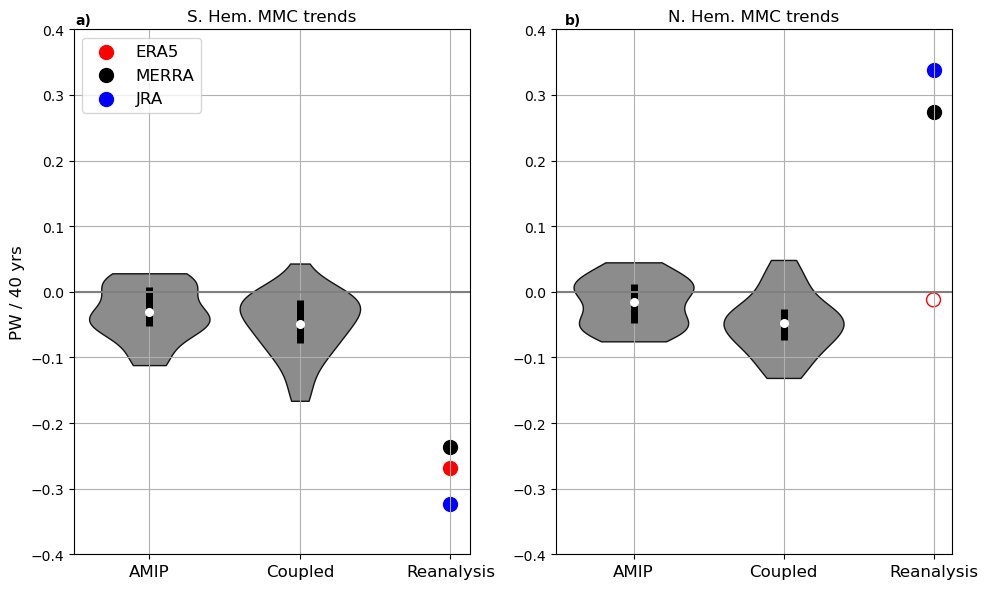

In [163]:
field = 'mmc_aht_polyfit_coefficients'
lat_slice1 = slice(-25, -10)
lat_slice2 = slice(10, 25)
ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = amip_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('S. Hem. MMC trends') 
axs['A'].axhline(0, color='grey')
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
violin_plot([amip_data, hist_data], axs['A'])
#axs['A'].boxplot([amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'], fontsize=12)

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field, lat_slice1)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, facecolors=['r', 'k', 'b'], s=100)
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs', fontsize=12)

amip_data = amip_trends[field].sel(latitude=lat_slice2).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field].sel(latitude=lat_slice2).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field].sel(latitude=lat_slice2).mean('latitude').sel(degree=1) * 40 / 1e15

axs['B'].set_title('N. Hem. MMC trends') 
axs['B'].axhline(0, color='grey')
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
violin_plot([amip_data, hist_data], axs['B'])
#axs['B'].boxplot([amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3])
axs['B'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'], fontsize=12)
#scatter = axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, facecolors=['r', 'k', 'b'], s=100)
axs['B'].grid()
axs['B'].set_ylim(ylim)
#axs['B'].set_ylabel('PW / 40 yrs')

classes = ['ERA5', 'MERRA2', 'JRA55']
values = [0,  1, 2]
colors = ListedColormap(['r','k','b'])

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field, lat_slice2)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)

#scatter = axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)


plt.scatter(20, 20, color='r', s=100, label='ERA5')
plt.scatter(20, 20, color='k', s=100, label='MERRA')
plt.scatter(20, 20, color='b', s=100, label='JRA')
plt.xlim([0.5, 3.13])
plt.legend(loc=2, fontsize=12)
#plt.legend(handles=scatter.legend_elements()[0], labels=classes, fontsize=12, loc=2)

fig.tight_layout()

fig.text(0.08, 0.95, 'a)', fontweight='semibold')
fig.text(0.57, 0.95, 'b)', fontweight='semibold')

#plt.savefig('../figures/mmc_aht_boxplots')
plt.show()

<ipython-input-164-9414db1387e0>:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['A'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-164-9414db1387e0>:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['A'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-164-9414db1387e0>:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['A'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-164-9414db1387e0>:49: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated si

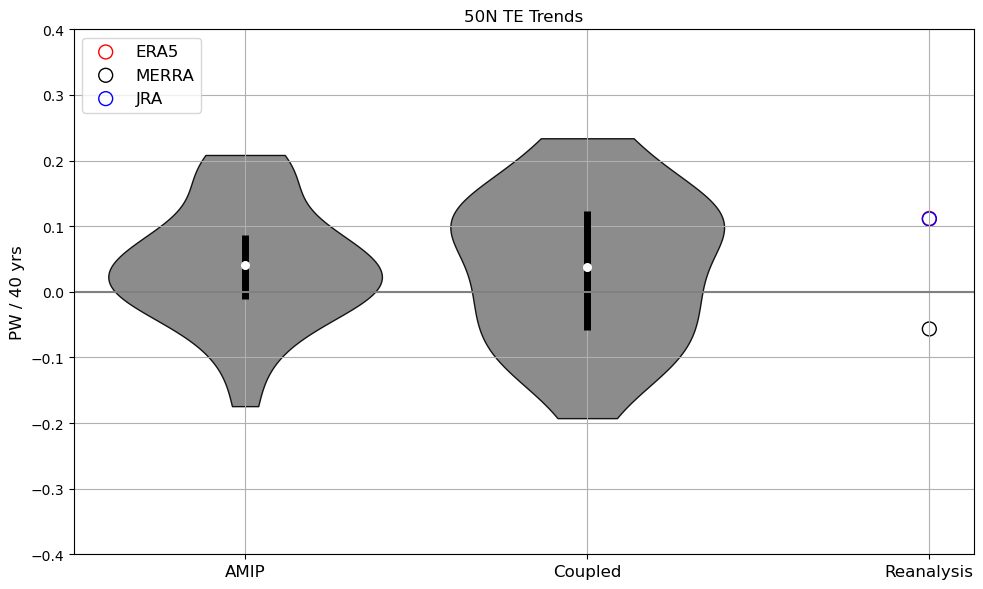

In [164]:
field = 'te_aht_polyfit_coefficients'
lat_slice1 = slice(49.5, 50.5)

ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = amip_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('50N TE Trends') 
axs['A'].axhline(0, color='grey')
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
violin_plot([amip_data, hist_data], axs['A'])
#axs['A'].boxplot([amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'], fontsize=12)
#axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, facecolors=['r', 'k', 'b'], s=100)
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs', fontsize=12)

classes = ['ERA5', 'MERRA2', 'JRA55']
values = [0,  1, 2]
colors = ListedColormap(['r','k','b'])

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field, lat_slice1)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#scatter = axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)

plt.scatter(20, 20, edgecolor='r', facecolor='',  s=100, label='ERA5')
plt.scatter(20, 20, edgecolor='k', facecolor='',  s=100, label='MERRA')
plt.scatter(20, 20, edgecolor='b', facecolor='',  s=100, label='JRA')
plt.xlim([0.5, 3.13])
plt.legend(loc=2, fontsize=12)
#plt.legend(handles=scatter.legend_elements()[0], labels=classes, fontsize=12, loc=2)

fig.tight_layout()

#plt.savefig('../figures/50n_te_boxplots')
plt.show()

<ipython-input-169-6c9159e88bbc>:36: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['A'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-169-6c9159e88bbc>:36: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['A'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-169-6c9159e88bbc>:36: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['A'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-169-6c9159e88bbc>:72: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated si

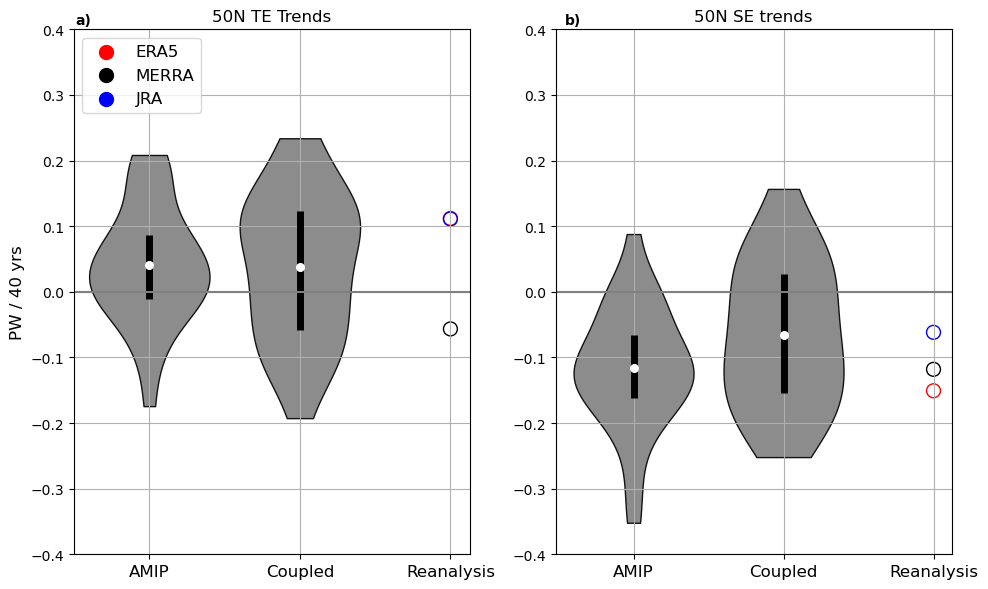

In [169]:
field1 = 'te_aht_polyfit_coefficients'
field2 = 'se_aht_polyfit_coefficients'
lat_slice1 = slice(49.5, 50.5)
ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = amip_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('50N TE Trends') 
axs['A'].axhline(0, color='grey')
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
violin_plot([amip_data, hist_data], axs['A'])
#axs['A'].boxplot([amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'], fontsize=12)

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field1, lat_slice1)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, facecolors=['r', 'k', 'b'], s=100)
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs', fontsize=12)

amip_data = amip_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15

axs['B'].set_title('50N SE trends') 
axs['B'].axhline(0, color='grey')
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
violin_plot([amip_data, hist_data], axs['B'])
#axs['B'].boxplot([amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3])
axs['B'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'], fontsize=12)
#scatter = axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, facecolors=['r', 'k', 'b'], s=100)
axs['B'].grid()
axs['B'].set_ylim(ylim)
#axs['B'].set_ylabel('PW / 40 yrs')

classes = ['ERA5', 'MERRA2', 'JRA55']
values = [0,  1, 2]
colors = ListedColormap(['r','k','b'])

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field2, lat_slice1)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#scatter = axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)

plt.scatter(20, 20, color='r', s=100, label='ERA5')
plt.scatter(20, 20, color='k', s=100, label='MERRA')
plt.scatter(20, 20, color='b', s=100, label='JRA')
plt.xlim([0.5, 3.13])
plt.legend(loc=2, fontsize=12)
#plt.legend(handles=scatter.legend_elements()[0], labels=classes, fontsize=12, loc=2)

fig.tight_layout()

fig.text(0.08, 0.95, 'a)', fontweight='semibold')
fig.text(0.57, 0.95, 'b)', fontweight='semibold')

#plt.savefig('../figures/50n_te_se_boxplots')
plt.show()

<ipython-input-167-5c0528925697>:36: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['A'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-167-5c0528925697>:36: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['A'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-167-5c0528925697>:72: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  axs['B'].scatter(3, reanalysis_data.sel(model=model),
<ipython-input-167-5c0528925697>:72: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated si

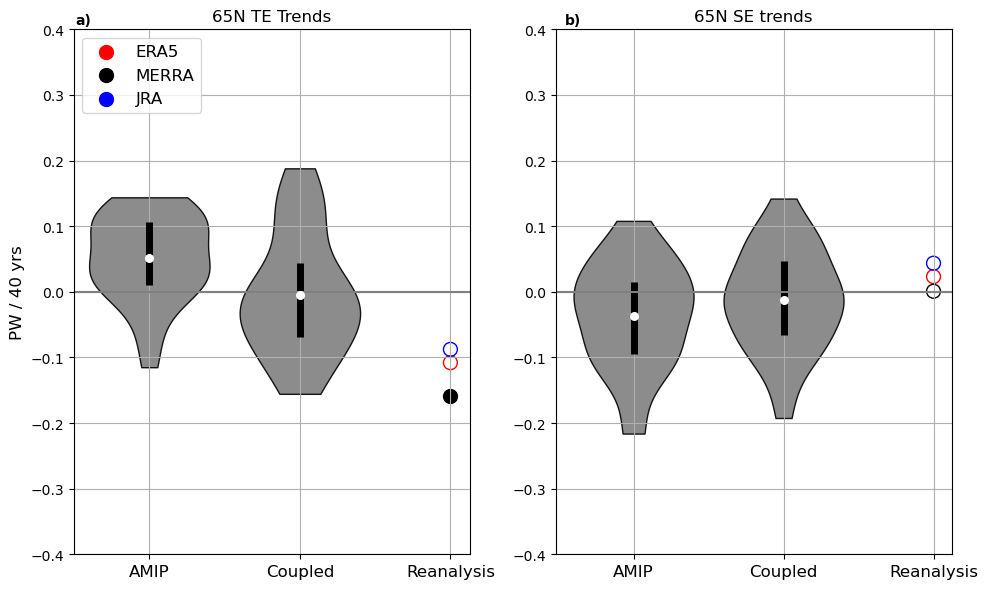

In [167]:
field1 = 'te_aht_polyfit_coefficients'
field2 = 'se_aht_polyfit_coefficients'
lat_slice1 = slice(64.5, 65.5)
ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = amip_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('65N TE Trends') 
axs['A'].axhline(0, color='grey')
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
violin_plot([amip_data, hist_data], axs['A'])
#axs['A'].boxplot([amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'], fontsize=12)

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field1, lat_slice1)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['A'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, facecolors=['r', 'k', 'b'], s=100)
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs', fontsize=12)

amip_data = amip_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15

axs['B'].set_title('65N SE trends') 
axs['B'].axhline(0, color='grey')
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
violin_plot([amip_data, hist_data], axs['B'])
#axs['B'].boxplot([amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3])
axs['B'].set_xticklabels(['AMIP', 'Coupled', 'Reanalysis'], fontsize=12)
#scatter = axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, facecolors=['r', 'k', 'b'], s=100)
axs['B'].grid()
axs['B'].set_ylim(ylim)
#axs['B'].set_ylabel('PW / 40 yrs')

classes = ['ERA5', 'MERRA2', 'JRA55']
values = [0,  1, 2]
colors = ListedColormap(['r','k','b'])

reanalysis_trend_sig = reanalysis_sig(reanalysis_data, field2, lat_slice1)
for model in reanalysis_trend_sig.model:
    
    if reanalysis_trend_sig.sel(model=model) == True:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    color=reanalysis_color_dict[str(model.values)], s=100)
        
    elif reanalysis_trend_sig.sel(model=model) == False:
        axs['B'].scatter(3, reanalysis_data.sel(model=model),
                    edgecolor=reanalysis_color_dict[str(model.values)], facecolor='', s=100)
        
#scatter = axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, c=values, cmap=colors, s=100)

plt.scatter(20, 20, color='r', s=100, label='ERA5')
plt.scatter(20, 20, color='k', s=100, label='MERRA')
plt.scatter(20, 20, color='b', s=100, label='JRA')
plt.xlim([0.5, 3.13])
plt.legend(loc=2, fontsize=12)
#plt.legend(handles=scatter.legend_elements()[0], labels=classes, fontsize=12, loc=2)

fig.tight_layout()

fig.text(0.08, 0.95, 'a)', fontweight='semibold')
fig.text(0.57, 0.95, 'b)', fontweight='semibold')

#plt.savefig('../figures/65n_te_se_boxplots')
plt.show()

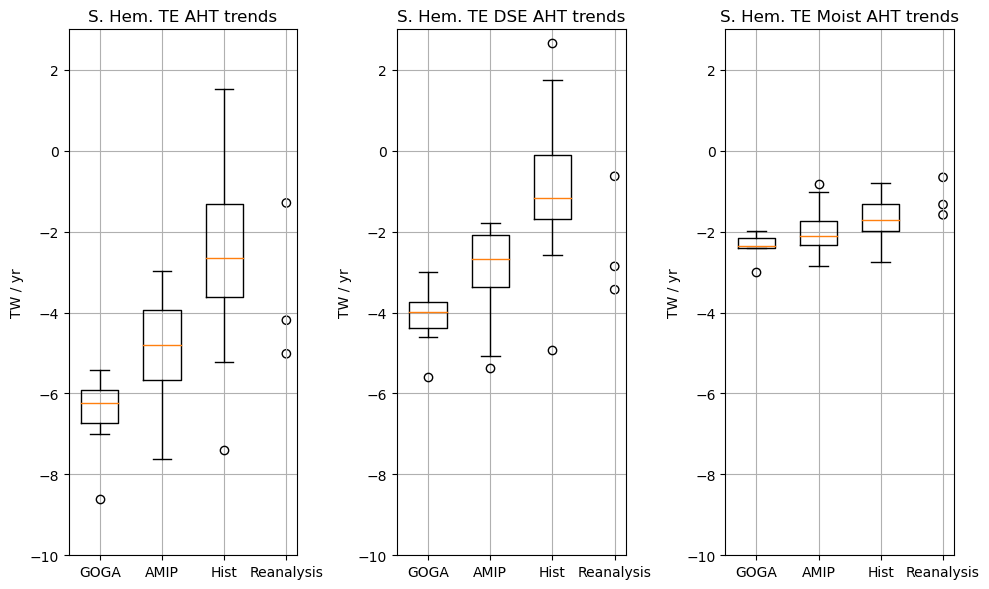

In [36]:
field1 = 'te_aht_polyfit_coefficients'
field2 = 'te_aht_dry_pot_polyfit_coefficients'
field3 = 'te_aht_moist_polyfit_coefficients'
lat_slice1 = slice(-70, -40)
ylim = [-10, 3]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B', 'C']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

goga_data = cesm2_amip_le_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
amip_data = amip_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
hist_data = hist_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
reanalysis_data = reanalysis_trends[field1].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12

axs['A'].set_title('S. Hem. TE AHT trends') 
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['A'].boxplot([goga_data, amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3, 4])
axs['A'].set_xticklabels(['GOGA', 'AMIP', 'Hist', 'Reanalysis'])
axs['A'].scatter(4 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors='k', facecolors='none')
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('TW / yr')

goga_data = cesm2_amip_le_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
amip_data = amip_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
hist_data = hist_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
reanalysis_data = reanalysis_trends[field2].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12

axs['B'].set_title('S. Hem. TE DSE AHT trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['B'].boxplot([goga_data, amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3, 4])
axs['B'].set_xticklabels(['GOGA', 'AMIP', 'Hist', 'Reanalysis'])
axs['B'].scatter(4 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors='k', facecolors='none')
axs['B'].grid()
axs['B'].set_ylim(ylim)
axs['B'].set_ylabel('TW / yr')

goga_data = cesm2_amip_le_trends[field3].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
amip_data = amip_trends[field3].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
hist_data = hist_trends[field3].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12
reanalysis_data = reanalysis_trends[field3].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) / 1e12

axs['C'].set_title('S. Hem. TE Moist AHT trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['C'].boxplot([goga_data, amip_data, hist_data], widths=box_width)
axs['C'].set_xticks([1, 2, 3, 4])
axs['C'].set_xticklabels(['GOGA', 'AMIP', 'Hist', 'Reanalysis'])
axs['C'].scatter(4 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors='k', facecolors='none')
axs['C'].grid()
axs['C'].set_ylim(ylim)
axs['C'].set_ylabel('TW / yr')

fig.tight_layout()

#plt.savefig('../figures/1_20_23_meeting/reanalysis_amip_hist_boxplots_n_s_hem_mmc_aht')
plt.show()

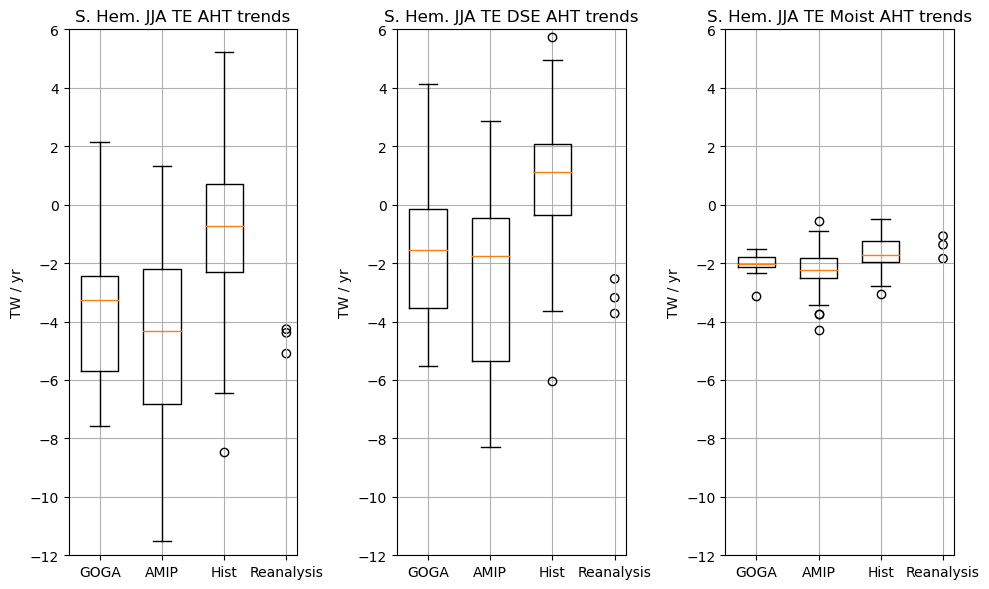

In [37]:
field1 = 'eddy_aht_polyfit_coefficients'
field2 = 'eddy_aht_dry_pot_polyfit_coefficients'
field3 = 'eddy_aht_moist_polyfit_coefficients'
lat_slice1 = slice(-70, -40)
ylim = [-12, 6]
which_months = [6, 7, 8]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B', 'C']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

goga_data = cesm2_amip_le_trends_month[field1].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
amip_data = amip_trends_month[field1].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
hist_data = hist_trends_month[field1].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
reanalysis_data = reanalysis_trends_month[field1].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12

axs['A'].set_title('S. Hem. JJA TE AHT trends') 
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['A'].boxplot([goga_data, amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3, 4])
axs['A'].set_xticklabels(['GOGA', 'AMIP', 'Hist', 'Reanalysis'])
axs['A'].scatter(4 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors='k', facecolors='none')
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('TW / yr')

goga_data = cesm2_amip_le_trends_month[field2].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
amip_data = amip_trends_month[field2].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
hist_data = hist_trends_month[field2].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
reanalysis_data = reanalysis_trends_month[field2].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12

axs['B'].set_title('S. Hem. JJA TE DSE AHT trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['B'].boxplot([goga_data, amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3, 4])
axs['B'].set_xticklabels(['GOGA', 'AMIP', 'Hist', 'Reanalysis'])
axs['B'].scatter(4 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors='k', facecolors='none')
axs['B'].grid()
axs['B'].set_ylim(ylim)
axs['B'].set_ylabel('TW / yr')

goga_data = cesm2_amip_le_trends_month[field3].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
amip_data = amip_trends_month[field3].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
hist_data = hist_trends_month[field3].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12
reanalysis_data = reanalysis_trends_month[field3].sel(month=which_months).mean('month').sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 1e15 / 40 / 1e12

axs['C'].set_title('S. Hem. JJA TE Moist AHT trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['C'].boxplot([goga_data, amip_data, hist_data], widths=box_width)
axs['C'].set_xticks([1, 2, 3, 4])
axs['C'].set_xticklabels(['GOGA', 'AMIP', 'Hist', 'Reanalysis'])
axs['C'].scatter(4 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors='k', facecolors='none')
axs['C'].grid()
axs['C'].set_ylim(ylim)
axs['C'].set_ylabel('TW / yr')

fig.tight_layout()

#plt.savefig('../figures/1_20_23_meeting/reanalysis_amip_hist_boxplots_n_s_hem_mmc_aht')
plt.show()

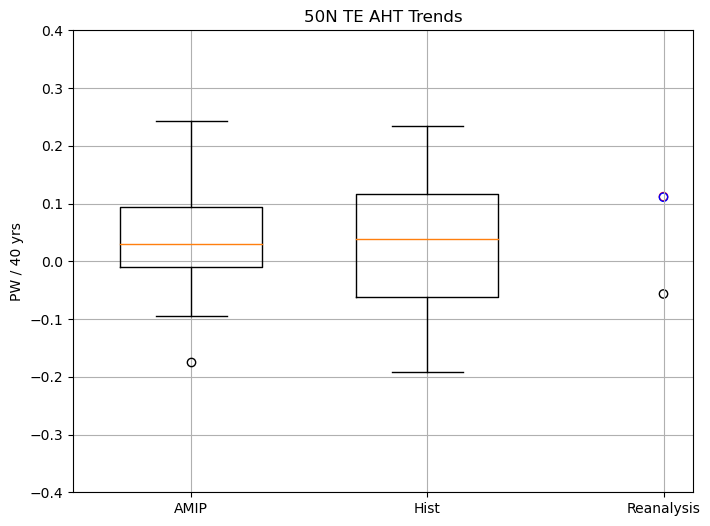

In [81]:
field = 'te_aht_polyfit_coefficients'
lat_slice1 = slice(49.5, 50.5)
ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B']]
plt.figure(figsize=(8,6))


amip_data = amip_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field].sel(latitude=lat_slice1).mean('latitude').sel(degree=1) * 40 / 1e15

plt.title('50N TE AHT Trends') 
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
plt.boxplot([amip_data, hist_data], widths=box_width)
plt.xticks([1, 2, 3])
plt.gca().set_xticklabels(['AMIP', 'Hist', 'Reanalysis'])
plt.scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')
plt.grid()
plt.ylim(ylim)
plt.ylabel('PW / 40 yrs')

#plt.savefig('../figures/1_20_23_meeting/reanalysis_amip_hist_boxplots_50n_te_aht')
plt.show()

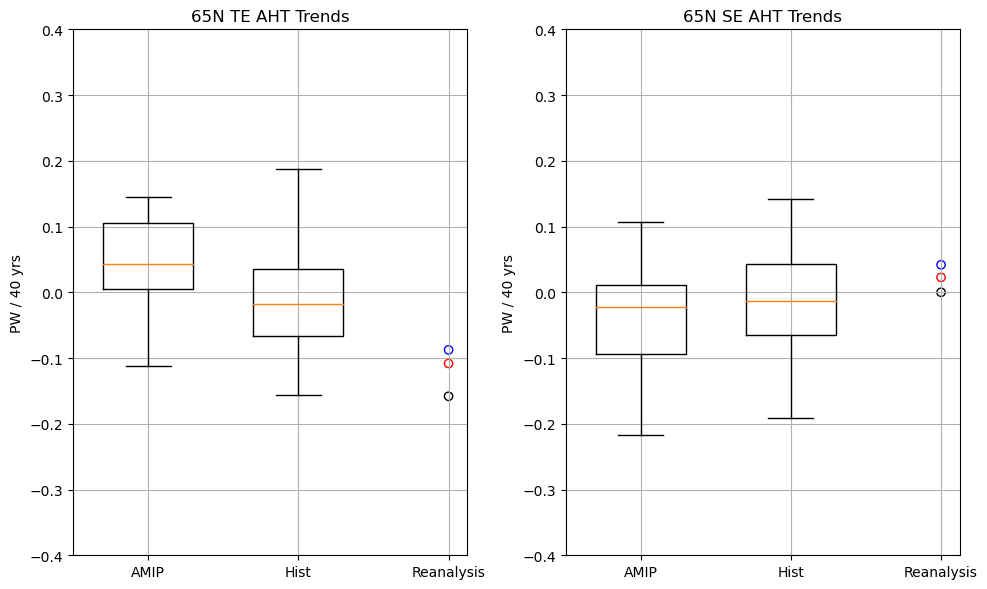

In [82]:
field1 = 'te_aht_polyfit_coefficients'
field2 = 'se_aht_polyfit_coefficients'
lat_slice = slice(64, 66)
ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['A', 'B']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = amip_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('65N TE AHT Trends') 
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['A'].boxplot([amip_data, hist_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['AMIP', 'Hist', 'Reanalysis'])
axs['A'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs')

amip_data = amip_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = hist_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['B'].set_title('65N SE AHT Trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['B'].boxplot([amip_data, hist_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3])
axs['B'].set_xticklabels(['AMIP', 'Hist', 'Reanalysis'])
axs['B'].scatter(3 * np.ones(len(reanalysis_data)), reanalysis_data, edgecolors=['r', 'k', 'b'], facecolors='none')
axs['B'].grid()
axs['B'].set_ylim(ylim)
axs['B'].set_ylabel('PW / 40 yrs')

fig.tight_layout()

#plt.savefig('../figures/1_20_23_meeting/reanalysis_amip_hist_boxplots_65n_te_se_aht')
plt.show()

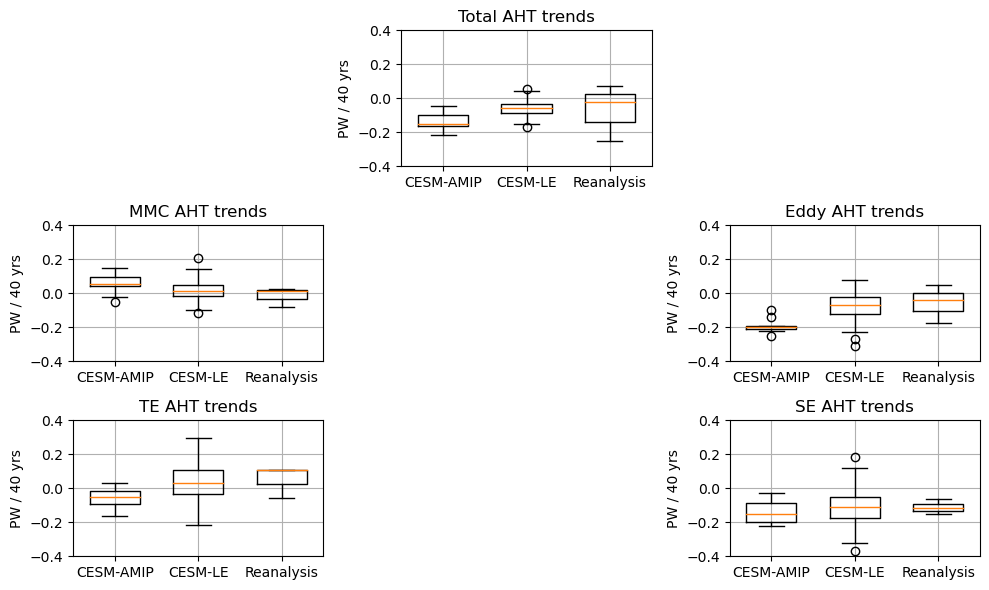

In [40]:
field1 = 'total_aht_polyfit_coefficients'
field2 = 'mmc_aht_polyfit_coefficients'
field3 = 'eddy_aht_polyfit_coefficients'
field4 = 'te_aht_polyfit_coefficients'
field5 = 'se_aht_polyfit_coefficients'
#which_lat = -60
lat_slice = slice(49, 51)
#lat_slice = slice(50, 70)
ylim = [-0.4, 0.4]
violin_width = 0.8
box_width = 0.6

#fig, axs = plt.subplots(2, 2,  figsize=(10, 6))
panel_order = [['.', 'A', '.'], ['B', '.', 'C'], ['D', '.', 'E']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

#amip_data = amip_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#hist_data = hist_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15
#reanalysis_data = reanalysis_trends[field].sel(latitude=which_lat).sel(degree=1) * 40 / 1e15

amip_data = cesm2_amip_le_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = cesm2_le_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field1].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['A'].set_title('Total AHT trends') 
#axs['A'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['A'].boxplot([amip_data, hist_data, reanalysis_data], widths=box_width)
axs['A'].set_xticks([1, 2, 3])
axs['A'].set_xticklabels(['CESM-AMIP', 'CESM-LE', 'Reanalysis'])
axs['A'].grid()
axs['A'].set_ylim(ylim)
axs['A'].set_ylabel('PW / 40 yrs')

amip_data = cesm2_amip_le_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = cesm2_le_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field2].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['B'].set_title('MMC AHT trends') 
#axs['B'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['B'].boxplot([amip_data, hist_data, reanalysis_data], widths=box_width)
axs['B'].set_xticks([1, 2, 3])
axs['B'].set_xticklabels(['CESM-AMIP', 'CESM-LE', 'Reanalysis'])
axs['B'].grid()
axs['B'].set_ylim(ylim)
axs['B'].set_ylabel('PW / 40 yrs')

amip_data = cesm2_amip_le_trends[field3].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = cesm2_le_trends[field3].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field3].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['C'].set_title('Eddy AHT trends') 
#axs['C'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['C'].boxplot([amip_data, hist_data, reanalysis_data], widths=box_width)
axs['C'].set_xticks([1, 2, 3])
axs['C'].set_xticklabels(['CESM-AMIP', 'CESM-LE', 'Reanalysis'])
axs['C'].grid()
axs['C'].set_ylim(ylim)
axs['C'].set_ylabel('PW / 40 yrs')

amip_data = cesm2_amip_le_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = cesm2_le_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field4].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['D'].set_title('TE AHT trends') 
#axs['D'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['D'].boxplot([amip_data, hist_data, reanalysis_data], widths=box_width)
axs['D'].set_xticks([1, 2, 3])
axs['D'].set_xticklabels(['CESM-AMIP', 'CESM-LE', 'Reanalysis'])
axs['D'].grid()
axs['D'].set_ylim(ylim)
axs['D'].set_ylabel('PW / 40 yrs')

amip_data = cesm2_amip_le_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
hist_data = cesm2_le_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15
reanalysis_data = reanalysis_trends[field5].sel(latitude=lat_slice).mean('latitude').sel(degree=1) * 40 / 1e15

axs['E'].set_title('SE AHT trends') 
#axs['E'].violinplot([amip_data, hist_data, reanalysis_data], showmeans=True, showextrema=False, widths=violin_width)
axs['E'].boxplot([amip_data, hist_data, reanalysis_data], widths=box_width)
axs['E'].set_xticks([1, 2, 3])
axs['E'].set_xticklabels(['CESM-AMIP', 'CESM-LE', 'Reanalysis'])
axs['E'].grid()
axs['E'].set_ylim(ylim)
axs['E'].set_ylabel('PW / 40 yrs')

fig.tight_layout()

#plt.savefig('../figures/aht_trends_paper_initials/reanalysis_cesm_amip_cesm_le_boxplots_60_45S_full_ahts')
plt.show()

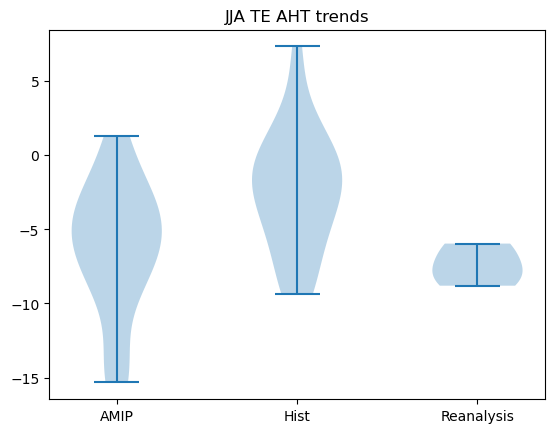

In [41]:

amip_data = amip_trends_month.eddy_aht_polyfit_coefficients.sel(latitude=slice(-51, -49)).mean(['latitude']).sel(degree=1).sel(month=[6, 7, 8]).mean('month')
hist_data = hist_trends_month.eddy_aht_polyfit_coefficients.sel(latitude=slice(-51, -49)).mean(['latitude']).sel(degree=1).sel(month=[6, 7, 8]).mean('month')
reanalysis_data = reanalysis_trends_month.eddy_aht_polyfit_coefficients.sel(latitude=slice(-51, -49)).mean(['latitude']).sel(degree=1).sel(month=[6, 7, 8]).mean('month')


plt.title('JJA TE AHT trends')
plt.violinplot([amip_data * 1000 / 40, hist_data * 1000 / 40, reanalysis_data * 1000 / 40])

plt.xticks([1, 2, 3], labels=['AMIP', 'Hist', 'Reanalysis'])

plt.show()